In [135]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

In [136]:
import sys
sys.path.append('..')

from models.classification_model import pipe
from models.cifar_classifier import CIFAR10_CLASSES

In [137]:
# Extract raw model from pipeline for gradients
backbone = pipe.model
processor = pipe.image_processor  # Use image_processor instead of feature_extractor

In [138]:
classifier = torch.nn.Linear(384, 10)
checkpoint = torch.load('../models/cifar10_linear_classifier.pth', map_location='cpu')
if 'model' in checkpoint:
    classifier.load_state_dict(checkpoint['model'])
else:
    classifier.load_state_dict(checkpoint)

# Move to the same device as the backbone
device = next(backbone.parameters()).device
classifier = classifier.to(device)
classifier.eval()

Linear(in_features=384, out_features=10, bias=True)

In [139]:
def classify_with_gradients(pixel_tensor):
    """Forward pass that allows gradients"""
    outputs = backbone(pixel_values=pixel_tensor)
    features = outputs.last_hidden_state[:, 0, :]  # Class token
    logits = classifier(features)
    return logits

In [140]:
def pgd_step(image_tensor, epsilon):
    """Single PGD attack step"""
    image_tensor = image_tensor.clone().detach()
    image_tensor.requires_grad = True

    # Get device
    device = image_tensor.device

    # Forward pass
    logits = classify_with_gradients(image_tensor)
    true_label = torch.argmax(logits).item()

    # Loss (maximize error)
    loss = F.cross_entropy(logits, torch.tensor([true_label], device=device))
    loss.backward()

    # PGD step
    adversarial = image_tensor + epsilon * image_tensor.grad.sign()
    return torch.clamp(adversarial, 0, 1).detach()

In [141]:
# Load and preprocess your test image
def load_test_image(path="../tmp_imgs/horse5.png"):
    image = Image.open(path).convert('RGB')

    # Use processor to convert to tensor
    inputs = processor(images=image, return_tensors="pt")
    pixel_tensor = inputs['pixel_values']

    # Move to the same device as the backbone
    device = next(backbone.parameters()).device
    pixel_tensor = pixel_tensor.to(device)

    return pixel_tensor, image

In [142]:
original_tensor, original_pil = load_test_image()

In [143]:
# Get original prediction
with torch.no_grad():
    orig_logits = classify_with_gradients(original_tensor)
    orig_pred = torch.argmax(orig_logits).item()
    orig_conf = F.softmax(orig_logits, dim=1).max().item()

In [144]:
print(f"Original Image Prediction: {CIFAR10_CLASSES[orig_pred]} with {orig_conf:.4f} confidence")

Original Image Prediction: horse with 0.9961 confidence


In [145]:
# Generate progressively corrupted images
epsilons = [0, 0.05, 0.1, 0.3, 0.42, 0.5, 0.8]  # Increasing epsilon values
corrupted_images = []
predictions = []

In [146]:
for eps in epsilons:
    if eps == 0:
        # Original
        corrupted = original_tensor
    else:
        # Apply PGD
        corrupted = pgd_step(original_tensor, eps)

    # Get prediction
    with torch.no_grad():
        logits = classify_with_gradients(corrupted)
        pred = torch.argmax(logits).item()
        conf = F.softmax(logits, dim=1).max().item()

    corrupted_images.append(corrupted)
    predictions.append((pred, conf))

    print(f"ε={eps:4.2f}: {CIFAR10_CLASSES[pred]} ({conf:.3f})")

ε=0.00: horse (0.996)
ε=0.05: deer (0.760)
ε=0.10: deer (0.841)
ε=0.30: cat (0.613)
ε=0.42: cat (0.731)
ε=0.50: cat (0.822)
ε=0.80: cat (0.793)


# Visualizing PGD Attack Results

Below we visualize the original image and how it changes with different epsilon values. We can see that as epsilon increases, the perturbation becomes more noticeable, and the model's prediction changes from the original class.

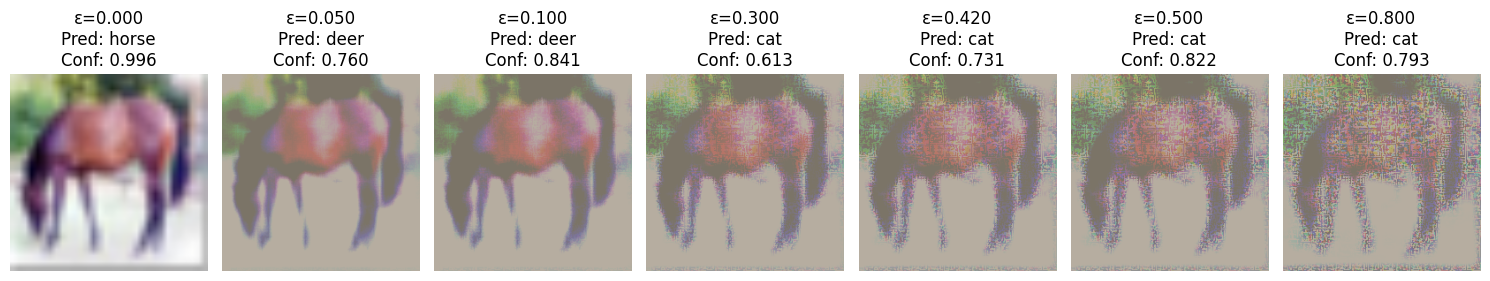

In [148]:

def tensor_to_pil(tensor):
    """Convert a normalized tensor to a PIL image for visualization"""
    img_tensor = tensor.detach().cpu().squeeze(0)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)


    img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    return Image.fromarray(img)


plt.figure(figsize=(15, 4))


for i, (eps, (pred, conf)) in enumerate(zip(epsilons, predictions)):
    plt.subplot(1, len(epsilons), i+1)

    img = tensor_to_pil(corrupted_images[i])

    plt.imshow(img)
    plt.title(f"ε={eps:.3f}\nPred: {CIFAR10_CLASSES[pred]}\nConf: {conf:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()